In [131]:
import relaqs.api.gates as gates
import numpy as np
import pandas as pd
import os
from datetime import datetime
from qutip.superoperator import liouvillian, spre, spost
from qutip import Qobj, tensor, Bloch, basis, sigmax, sigmay, sigmaz, expect
from qutip.operators import *
import matplotlib.pyplot as plt
from relaqs.api.utils import *
from scipy.linalg import expm

In [74]:
I = gates.I().get_matrix()
X = gates.X().get_matrix()
Y = gates.Y().get_matrix()
Z = gates.Z().get_matrix()

In [196]:
steps_per_Haar = 1
final_time = 35.5556E-9 #in seconds
gamma_phase_max = 1.1675 * np.pi
gamma_magnitude_max = 1.8 * np.pi / final_time / steps_per_Haar
alpha_max = 0.05E9  # detuning of the control pulse in Hz

In [204]:
def compare_actions_U_target(action,u_target):
    # gamma_magnitude_action, gamma_phase_action, alpha_action = action
    # action = [0.18149161,0.97111285,-0.45888507]
    # u_target = [[-0.26685747-0.43349986j ,0.36620598-0.77894681j],
    #             [-0.36620598-0.77894681j ,-0.26685747+0.43349986j]]
    # Compute actual control parameters
    gamma_magnitude = gamma_magnitude_max/2 * (action[0]+1)
    gamma_phase = gamma_phase_max * action[1]
    alpha = alpha_max * action[2]

    print(f"alpha: {alpha}\n")
    # print(f"U_target: {u_target}\n")

    detuing_list = [944.5591192245483, 20663.88058757782, 7009.451946258545, 3041.243444442749, 2786.565857887268, 15716.49913406372, 3330.534860610962, 3041.243444442749, 3041.243444442749]
    # Construct the Hamiltonian
    # H = alpha * Z + gamma_magnitude * (np.cos(gamma_phase) * X + np.sin(gamma_phase) * Y)
    psi_0 = np.array([[1], [0]], dtype=complex)  # |0⟩ state
    # psi_0 = basis(2, 0)
    bloch_points = []
    for detuning in detuing_list:
        H = (detuning + alpha)*Z + gamma_magnitude*(np.cos(gamma_phase)*X + np.sin(gamma_phase)*Y)
    # H = alpha * sigmaz() + gamma_magnitude * (np.cos(gamma_phase) * sigmax()
    #                                      + np.sin(gamma_phase) * sigmay())

        # Compute Unitary Evolution: U = exp(-i H t)
        U = expm(-1j * H * final_time)
        # U = (-1j * H * final_time).expm()
        # print(f"Generated U:\n{U}")

        # Apply U to initial state |0⟩
        psi_final = U @ psi_0
        # psi_final = U * psi_0  # Evolve under U

        # # Compute the Density Matrix: ρ = |ψ⟩⟨ψ|
        rho = psi_final @ psi_final.conj().T

        # Compute Bloch vector components: (x, y, z)
        x = np.real(np.trace(rho @ X))
        y = np.real(np.trace(rho @ Y))
        z = np.real(np.trace(rho @ Z))
        # x = expect(sigmax(), psi_final)
        # y = expect(sigmay(), psi_final)
        # z = expect(sigmaz(), psi_final)
        bloch_points.append(np.array([x,y,z]))



    vector = np.matmul(u_target, np.array([[1], [0]]))  # Apply gate to |0⟩ = [1, 0]^T
    q_obj = qutip.Qobj(vector)  # Convert the resulting vector to a QuTiP quantum object


    bloch_sphere = Bloch()
    bloch_sphere.vector_color = ['m']  # Magenta for clarity

    # Add Bloch vectors
    for point in bloch_points:
        bloch_sphere.add_points(point.T)  # Transpose needed for correct format
    bloch_sphere.add_states(q_obj)
    # bloch_sphere.add_states(qutip.Qobj(psi_final))

    # # Prevent cropping by modifying rendering settings
    # bloch_sphere.frame_alpha = 0.3  # Make the Bloch sphere frame slightly transparent
    # bloch_sphere.font_size = 10  # Reduce font size to prevent label overlap
    # bloch_sphere.scale = [1.0]  # Maintain default scaling to avoid zooming issues

    # Show Bloch sphere
    # bloch_sphere.view = [120,30]
    bloch_sphere.show()



In [198]:
def unitary_to_superoperator(U):
    S1 = np.kron(U.conj(), U)
    S2 = np.kron(U, U.conj())
    S3 = np.array((spre(Qobj(U)) * spost(Qobj(U))).data.toarray())
    return S1, S2, S3

In [199]:
def process_fidelity(S1, S2):
    d = int(np.sqrt(S1.shape[0]))  # Extract system dimension
    return np.abs(np.trace(S1.conj().T @ S2)) / d**2

In [200]:
def eigenvalue_distance(S1, S2):
    eigs1 = np.linalg.eigvals(S1)
    eigs2 = np.linalg.eigvals(S2)
    return np.linalg.norm(eigs1 - eigs2)


In [201]:
def is_close_superoperator(S1, S2, tol=1e-6):
    return np.allclose(S1, S2, atol=tol)

In [202]:
def frobenius_distance(S1, S2):
    return np.linalg.norm(S1 - S2, ord='fro')  # Frobenius norm

0.9949318709060032
alpha: -49998355.0



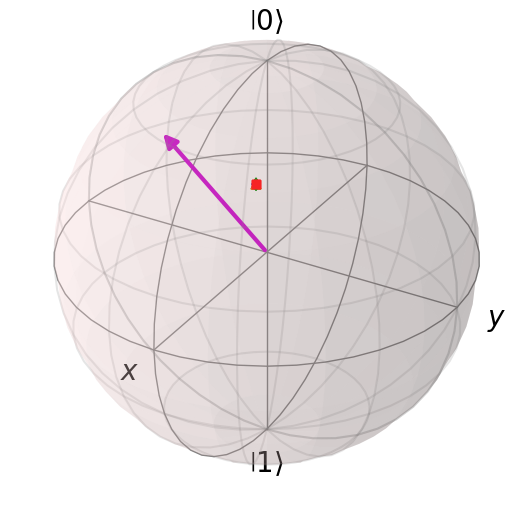


------------------------------------------------

0.9976828032791912
alpha: -9114608.0



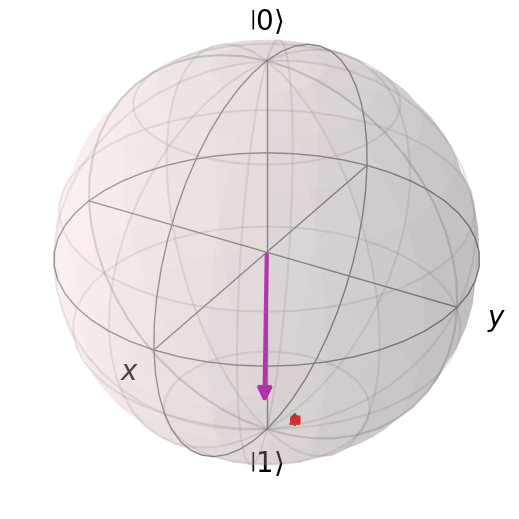


------------------------------------------------

0.9935403108190228
alpha: 1066041.0



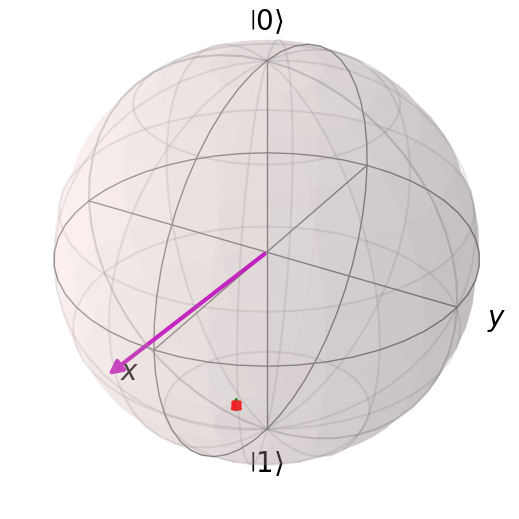


------------------------------------------------

0.9962284233711228
alpha: 17804539.0



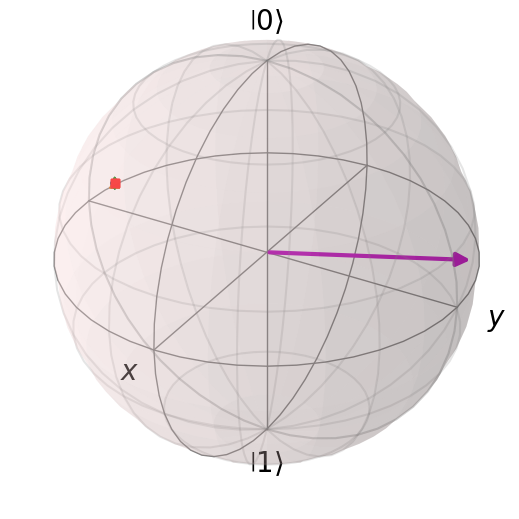


------------------------------------------------

0.9988121490279048
alpha: -33251998.0



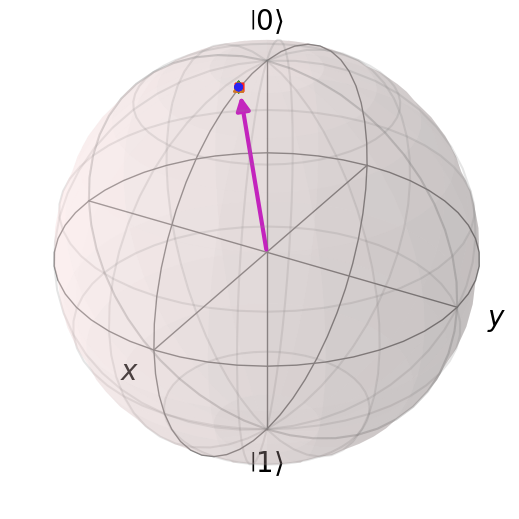


------------------------------------------------

0.9974070743349625
alpha: -7116844.999999999



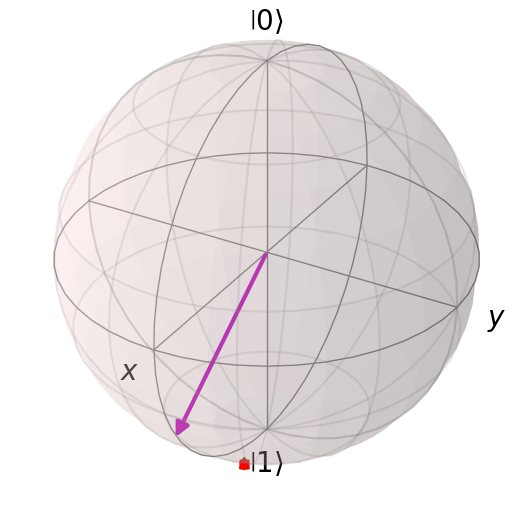


------------------------------------------------

0.9948190367653182
alpha: 6514900.999999999



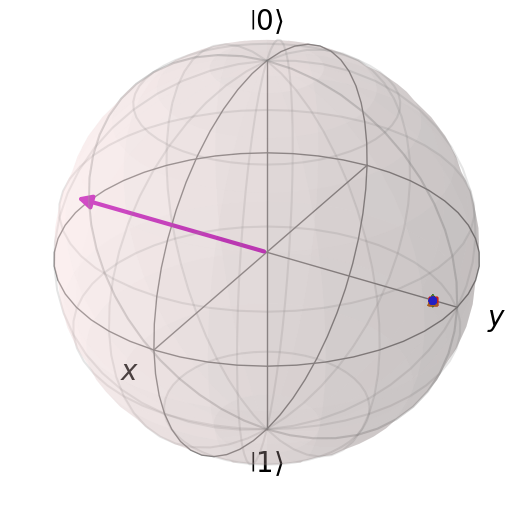


------------------------------------------------

0.9981010180714628
alpha: -21023553.5



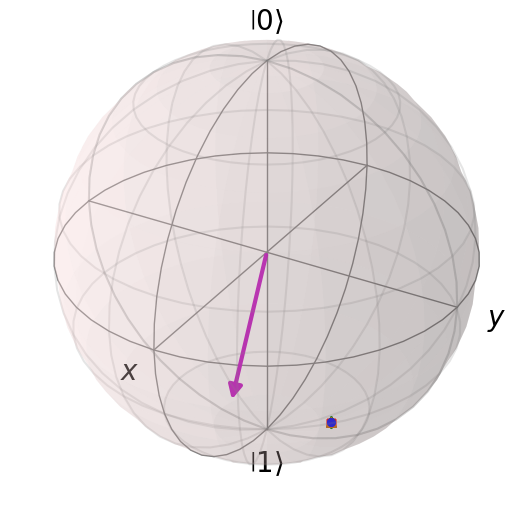


------------------------------------------------

0.9985001140727556
alpha: -21434396.5



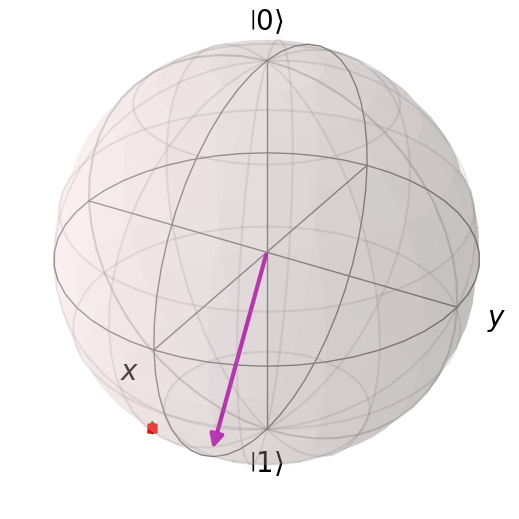


------------------------------------------------

0.994860664018798
alpha: -15824815.0



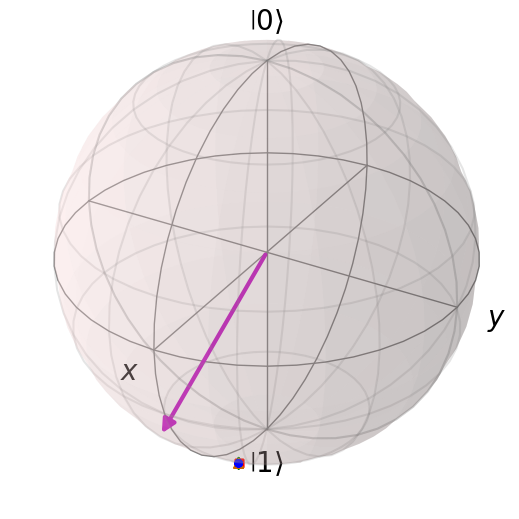


------------------------------------------------

0.9976471035454128
alpha: -48983860.0



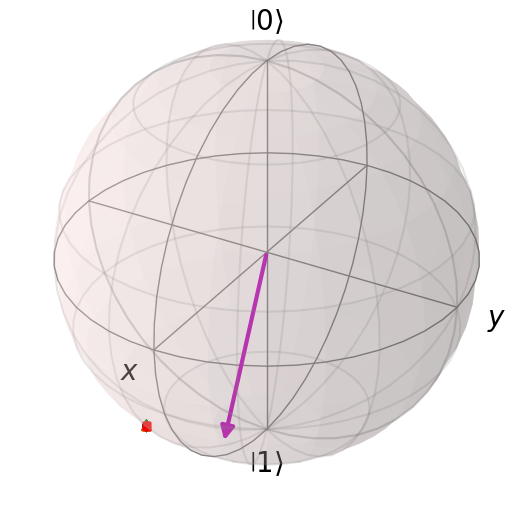


------------------------------------------------

0.996561840756161
alpha: -41911890.0



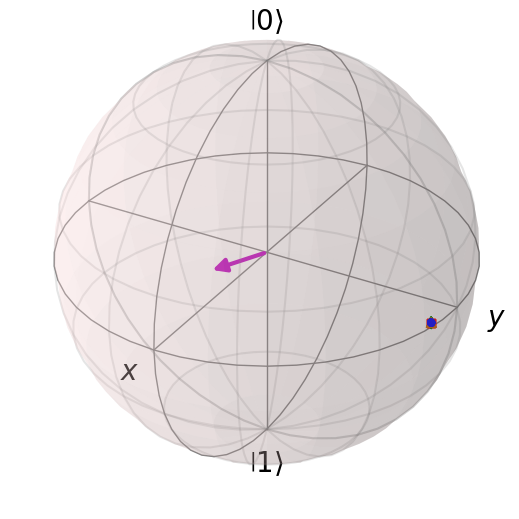


------------------------------------------------

0.9989166749538632
alpha: -37877962.0



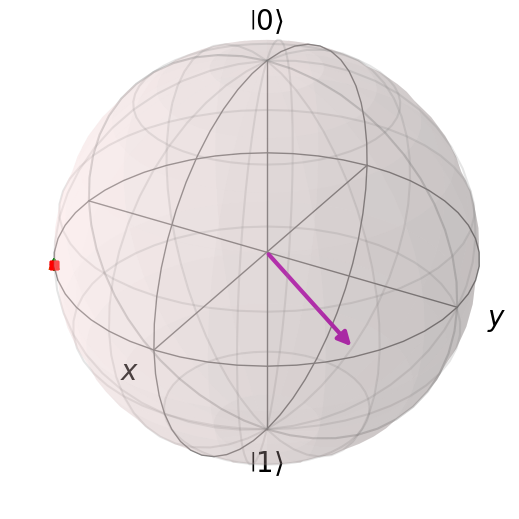


------------------------------------------------

0.9912967390514388
alpha: -48943100.0



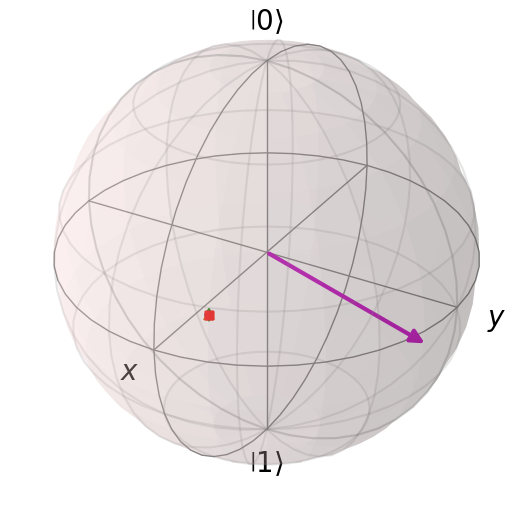


------------------------------------------------

0.9975721477850324
alpha: 41640885.0



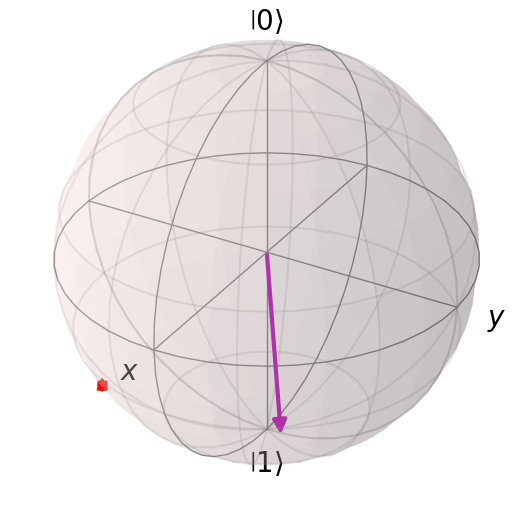


------------------------------------------------



In [207]:
data_path = '/Users/vishchaudhary/rl-repo/results/2025-03-02_16-18-03/RandomSU2/RandomSU2_env_data.csv'
df = pd.read_csv(data_path,header = 0)

fidelities = df.iloc[:, 0]
preprocessed_actions = df.iloc[:, 2].apply(preprocess_actions)
preprocessed_operator = df.iloc[:, 3].apply(preprocess_matrix_string)
preprocessed_target_operator = df.iloc[:, 4].apply(preprocess_matrix_string)
preprocessed_U_target = df.iloc[:, 5].apply(preprocess_matrix_string)

actions_array = [np.array(eval(m)) for m in preprocessed_actions]
u_target_list = [np.array(eval(m)) for m in preprocessed_U_target]
u_target_list = np.array(u_target_list)

operator = [np.array(eval(m)) for m in preprocessed_operator]
operator = np.array(operator)

target_operator = [np.array(eval(m)) for m in preprocessed_target_operator]
target_operator = np.array(target_operator)

for i in range(30):
    if fidelities[i] > 0.99:
        print(fidelities[i])
        # print(u_target_list[i])
        # print(f"{check_unitary(u_target_list[i])}")
        # S1, S2, S3 = unitary_to_superoperator(u_target_list[i])
        # print(f"S1:\n{S1}\nS2:\n{S2}\nS3:\n{S3}\n")

        # print(f"Process Fidelity(if close to 1 gates are close): {process_fidelity(operator[i], target_operator[i])}")
        # print(f"Eigenvalue Distance(Smaller values indicate greater similarity): {eigenvalue_distance(operator[i], target_operator[i])}")
        # print(f"Frobenius Norm Distance: {frobenius_distance(operator[i], target_operator[i])}")
        # psi = np.random.rand(4, 1) + 1j * np.random.rand(4, 1)
        # psi /= np.linalg.norm(psi)  # Normalize random state
        #
        # psi1 = operator[i] @ psi
        # psi2 = target_operator @ psi
        #
        # state_diff = np.linalg.norm(psi1 - psi2)
        # print(f"State transformation difference: {state_diff}\n")
        # if is_close_superoperator(operator[i], target_operator[i]):
        #     print("Superoperators are close!")
        # else:
        #     print("Superoperators are different.")
        compare_actions_U_target(actions_array[i], u_target_list[i])
        print(f"\n------------------------------------------------\n")
